In [1]:
%%time
%matplotlib inline
from new_import import *

CPU times: user 13 s, sys: 4.19 s, total: 17.2 s
Wall time: 10.8 s


In [2]:
%%time
# Dask gateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
dc = datacube.Datacube()

# Configure s3 access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

client

An existing cluster was found. Connecting to: easihub.9f2f42f40c134601a68634913d891637
CPU times: user 745 ms, sys: 23 ms, total: 769 ms
Wall time: 975 ms


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.9f2f42f40c134601a68634913d891637/status,


In [3]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.86575, 105.94120)
latitude_range = (9.65070, 9.69850)

In [4]:
## truy vấn ảnh vệ tinh sen2
data = load_data(dc, date_range, longtitude_range, latitude_range)
notebook_utils.heading(notebook_utils.xarray_object_size(data))
display(data)

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 78, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_clean(data)
progress(result)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 114 ms, sys: 4.28 ms, total: 118 ms
Wall time: 116 ms


VBox()

In [7]:
# Tiến hành tính toán NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 78, y: 532, x: 830)>
dask.array<truediv, shape=(78, 532, 830), dtype=float32, chunksize=(1, 532, 830), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648

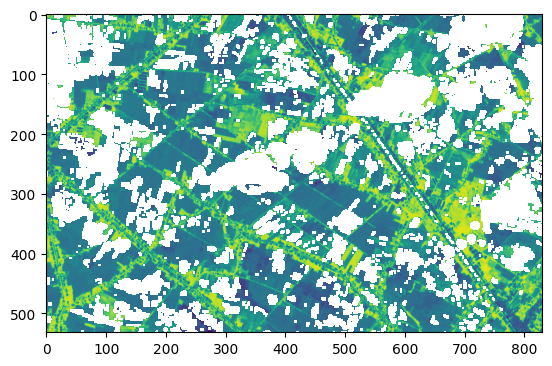

In [8]:
## ảnh ndvi chưa fill nan
plt.imshow(ndvi.isel(time=50))

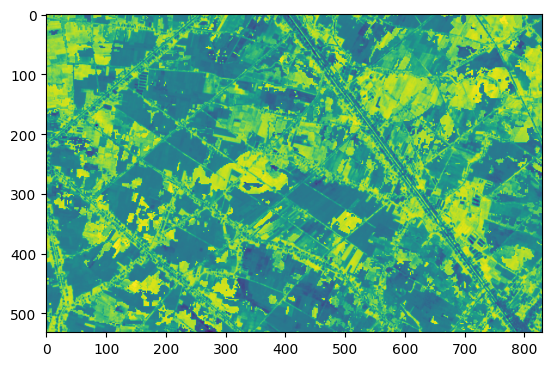

In [9]:
# đặt thời gian các mùa
time_split = [slice('2022-09-01', '2023-01-01'), 
               slice('2023-01-01', '2023-05-01'),
               slice('2023-05-01', '2023-07-01'),
               slice('2023-07-01', '2023-10-01')]

# fill nan
fill_nan_ndvi = fill_nan(ndvi, time_split)

## ảnh ndivi đã fill nan
plt.imshow(fill_nan_ndvi.isel(time=50))

In [10]:
%%time
## tính ndvi theo tháng
average_ndvi = fill_nan_ndvi.resample(time='1M').mean().persist()
progress(average_ndvi)

CPU times: user 81.8 ms, sys: 460 µs, total: 82.3 ms
Wall time: 80.1 ms


VBox()

In [11]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

## cấu hình shapefile ranh giới thuận hòa và vh vv file
thuanhoa_path = "ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"
name_vh = "ThuanHoa/ThuanHoa_VH.tif"
name_vv = "ThuanHoa/ThuanHoa_VV.tif"

# load dữ liệu sen1
dsvh, dsvv = load_sen1(name_vh, name_vv)

In [12]:
# load model RF
loaded_model = joblib.load(os.path.join("model_train", "model_new.joblib"))

# dự đoán
data_array = predict(loaded_model, data.rio.crs, average_ndvi, dsvh, dsvv)

In [13]:
# cấu hình màu cho các loại đất
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

/tmp/ipykernel_19517/2294385133.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


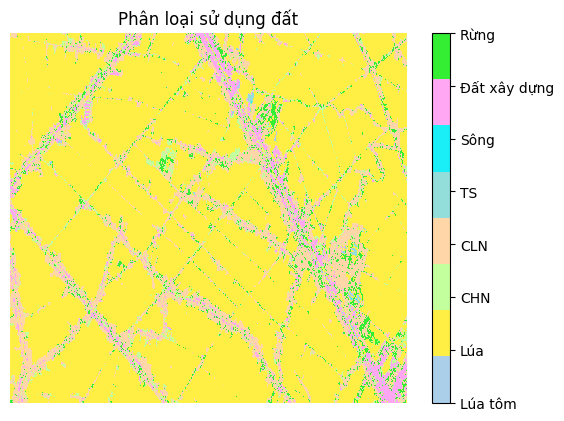

In [14]:
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [15]:
# cắt theo ranh giới xã thuận hòa
region_result = cut_according_shp(thuanhoa_path, average_ndvi, data_array)

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [16]:
# hiển thị kết quả phân loại sử dụng đất
colorval = list(range(len(colors)))
options = {
    'title': 'Phân loại sử dụng đất',
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
region_result.hvplot(
    rasterize = True,                        # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),          # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

:DynamicMap   []
   :Image   [x,y]   (value)

In [19]:
# Lưu lại kết quả
region_result.rio.to_raster("KetQuaPhanLoaiDat_new.tif")

In [18]:
# đóng client, cluster
client.close()
cluster.close()